<h1 style="color: rebeccapurple;">Evaluation – A Quick Detour</h1>
<span style="text-transform: uppercase;
        font-size: 14px;
        letter-spacing: 1px;
        font-family: 'Segoe UI', sans-serif;">
    Author
</span><br>
efrén cruz cortés
<hr style="border: none; height: 1px; background: linear-gradient(to right, transparent 0%, #ccc 10%, transparent 100%); margin-top: 10px;">

So far we have seen two tasks:
- Regression
- Classification

For regression, we evaluated our result based on the coefficient of determination $R^2$. For classification we evaluated using the proportion of correct predictions (accuracy). Let's take a closer look at evaluation metrics. We will focus on classification as it is likely you're less familiar with it.

Evaluation is important to compare how different models perform on the same task, or to choose the best hyperparameters for a given model. Soon we will learn about `cross-validation`, where evaluation plays an important role.

## <span style="color:darkorchid"> Imports and data

In [1]:
# Scikit-learn specifics:
from sklearn import datasets
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm

# Helper modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# :: DATA ::

try:
    import google.colab
    !wget https://raw.githubusercontent.com/nuitrcs/scikit-learn-workshop-july2025/refs/heads/main/data/red_wine_binary.csv
    !wget https://raw.githubusercontent.com/nuitrcs/scikit-learn-workshop-july2025/refs/heads/main/data/red_wine_binary_imbalanced.csv
    red_wine_directory = "red_wine_binary.csv"
    red_wine_imbalanced_directory = "red_wine_binary_imbalanced.csv"
    print("Successfully loaded files to Colab. Check folder on left column.")
except ModuleNotFoundError:
    red_wine_directory = "data/red_wine_binary.csv"
    red_wine_imbalanced_directory = "data/red_wine_binary_imbalanced.csv"
    print("Data should be in your local directory. Under the 'data' folder.")

Data should be in your local directory. Under the 'data' folder.


## <span style="color:darkorchid"> Classification Metrics

To simplify our discussion, we will first focus on binary classification. The extension to multi-class classification is fairly straighforward, and we'll talk about it at the end.

Most classification metrics are based on the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). Let's take a quick look at what that is so we develop an intuition.

### <span style="color:darkorange"> Conceptual Intermezzo - Confusion Matrix

See slides

### <span style="color:teal">Alice's Surprising Success

After Alice shows her extraordinary sommerlier skills in Italy, Portuguese growers ask for help. They want to be able to identify, based on chemical composition, the quality of the wine (as opposed to variety, as in Italy). In this case, our wines are either high quality or standard, making it a binary classification problem. Let's take a look at our data:

In [54]:
port_wine = pd.read_csv(red_wine_directory)
port_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Since we know how to build a classification pipeline, let's do so. Ideally we would choose the appropriate scaler for each column, for example, we may want to limit `pH` to the range $[0,14]$ using a min max scaler, but to keep things simple let's standardize everything.

In [55]:
pX = port_wine.drop(['quality'], axis='columns')
py = port_wine['quality']
pX_train, pX_test, py_train, py_test = train_test_split(pX, py, stratify=py, test_size=.3, random_state=42)

port_wine_pipeline = Pipeline(
    [
        ("preprocessor", preprocessing.StandardScaler()),
        ("classifier", svm.SVC())
    ]
)

port_wine_pipeline.fit(pX_train, py_train)

Pipeline(steps=[('preprocessor', StandardScaler()), ('classifier', SVC())])

As a reminder, in our previous classification pipelines, we obtained the accuracy by calling the `.score()` method. Let's explore this further.

In [56]:
port_wine_pipeline.score(pX_test, py_test)

0.9041666666666667

### <span style="color:teal"> Accuracy

Accuracy is given by the proportion of correct predictions, among all classes. For example, if we predicted correctly $87$ cases out of $100$, independent of which class those successful cases were on, then the accuracy would be $.87$.
$$
accuracy = \frac{\text{number of correct predictions}}{n}
$$
This may intuitively seem the natural metric for performance, and it's fine for quite a few cases, but it may fail.

Imagine you have an unbalanced dataset, where 99% of observations come from one class (call it $C_1$), and only $1\%$ from the other. I can have a very simple classifier that always predicts $C_1$. If my test data is also split $99/1$, I will have an accuracy of $99%$!!

But what if the $1\%$ which is a very rare occurrance, is actually of high impact? This is common, for example, with medical diagnosis: even if the percentage of a disease in a population is small, we want to be able to properly diagnose it!

### <span style="color:teal"> Classification Report
We can get more measures of performance with a `classification report` from the `metrics` module:

In [57]:
py_pred = port_wine_pipeline.predict(pX_test)
print(metrics.classification_report(py_test, py_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       415
           1       0.88      0.34      0.49        65

    accuracy                           0.90       480
   macro avg       0.89      0.67      0.72       480
weighted avg       0.90      0.90      0.89       480



- **Precision** for a class $C$ is the proportion of observations correctly classified as class $C$ out of everything classified as $C$. The higher the better.
- **Recall** for a class $C$ is the proportion of observations correctly classified as class $C$ out of everything that was actually from $C$. The higher the better.
- **$F_1$ Score** Is a type of average of precision and recall. It can show us the tradeoff between these two. The higher the better.
- **Support** The number of test observations of each class.

In our example above, our classifier performed much better on class $0$ (standard quality wines) than on class $1$ (high quality wines). Notice we have way more examples of standard wines.

**Averages**
- The macro average is just the average over all classes.
- The weighted average considers the relative number of observations for each class.

STOP!!

Let's think a little bit about each of these results.

1. Let's think about precision and recall for each class.
2. Let's think about averages:

For example, our recall macro average is $67$, not that great. This is because our performance on high quality wines is very poor. However, we don't have that many high quality wines overall, so it's unlikely we will encounter them. If that is the case, and errors on class $0$ and class $1$ are equally important, we may prefer the weighted average to account for our good performance on standard wines, which is most of the time.

HOWEVER, some errors may be much more important than others. What if class $1$, for example, was a rare disease? We definitely don't want to downplay poor performance just because the disease is rare.

#### <span style="color:blue">Example - Imbalanced Dataset</span>

I have prepared an imbalanced version of the wine dataset. Here only the highest quality wines are labeled as positive. Wines for true snobs.

In [58]:
imb_wine = pd.read_csv(red_wine_imbalanced_directory)
imb_wine['quality'].value_counts()

quality
0    1581
1      18
Name: count, dtype: int64

Let's create the classifier:

In [59]:
# Split the data
imb_X = imb_wine.drop(['quality'], axis='columns')
imb_y = imb_wine['quality']
iX_train, iX_test, iy_train, iy_test = train_test_split(imb_X, imb_y, test_size=.2, stratify=imb_y, random_state=42)
# stratify makes sure we keep a similar proportion of  each label in the test dataset

In [60]:
# Create and train classifier on imbalanced data
imb_clf = svm.SVC().fit(iX_train, iy_train)

For comparison, let's create a simple classifier that always predicts $0$, no matter what.

In [61]:
# Simple classifier for comparison
def simple_clf_score(X, y):
    prediction = 0
    correct_n = sum(y==prediction)
    accuracy = correct_n / len(X)
    return accuracy

In [62]:
# Compute accuracy
svm_acc = imb_clf.score(iX_test, iy_test)
dc_acc = simple_clf_score(iX_test, iy_test)

print(f"SVM's accuracy: {svm_acc:.2f}\nSimple classifier accuracy: {dc_acc:.2f}")

SVM's accuracy: 0.99
Simple classifier accuracy: 0.99


So the SVM is doing just as well as my classifier which just predicts the $0$ label (indeed, the SVM is JUST predcting the 0 label).

In [63]:
iy_pred = imb_clf.predict(iX_test)
print(metrics.classification_report(iy_test, iy_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       316
           1       0.00      0.00      0.00         4

    accuracy                           0.99       320
   macro avg       0.49      0.50      0.50       320
weighted avg       0.98      0.99      0.98       320



(You may notice the `zero_division` parameter. This is to handle the fact that our classifier never predicts $1$)

#### <span style="color:red">EXERCISE</span>
<hr>

1. Take a look at the confusion matrix in the slides and discuss with your neighbor the meaning of some terms like FPR, TPR or Recall and Precision.
2. Take a minute to think alone about the classification report for the extremely imabalanced wine dataset, try to interpret the results. Discuss with your neighbor.
3. Looking at precision for class $0$, why is it so good compared to class $1$? How is this related to the class imbalance?
4. Why are the macro and weighted averages so different? When would you use one or the other?

<hr>

**There's much more to this!**

At this point, you may realize it is not so straightforward to decide what to focus on when it comes to performance. For example:
- In medical diagnosis, if your classifier focuses on not missing any positive, it may yield a lot of false positives, freaking out a lot of people. Confirmatory tests are used to ameliorate the situation.
- When it comes to weather warnings, you definitely don't want to miss any (for example earthquakes, tornadoes, etc.)! However, you don't want to have so many false positives that the general population will stop believing in you, leading to a boy who cried wolf scenario.
- We don't have time to discuss this further, but a fun article would be the [base rate fallacy](https://en.wikipedia.org/wiki/Base_rate_fallacy).

### <span style="color:teal"> The `metrics` module

Since the `.score()` method only returns accuracy, sklearn provides a handy way to obtain other metrics through the `metrics` module. This will come in handy if you compare models according to a given metric that is not the default.

`metrics` has access to a wide variety of metrics for both classification and regression, some more exotic than others. Here we'll just see how to obtain individually some standard metrics.

Let's switch back to our original, less imablanced portuguese wine dataset.

#### Standard Metrics

In [79]:
# Back to the slightly more balanced dataset

# We'll need the predicted values on the test data
py_pred = port_wine_pipeline.predict(pX_test)

# We can extract a variety of metrics, let's start with the ones from the classification report:
pw_clf_acc = metrics.accuracy_score(py_test, py_pred) # this is the same as using .score()
pw_clf_prec = metrics.precision_score(py_test, py_pred) # this will compute the precision
pw_clf_recall = metrics.recall_score(py_test, py_pred)
pw_clf_f1 = metrics.f1_score(py_test, py_pred)

metrics_summary = f"""
Accuracy: {pw_clf_acc:.2f}
Precission: {pw_clf_prec:.2f}
Recall: {pw_clf_recall:.2f}
F1 Score: {pw_clf_f1:.2f}
"""
print(metrics_summary)


Accuracy: 0.90
Precission: 0.88
Recall: 0.34
F1 Score: 0.49



#### The Confusion Matrix in scikit-learn

Confusion matrix:
[[412   3]
 [ 43  22]]


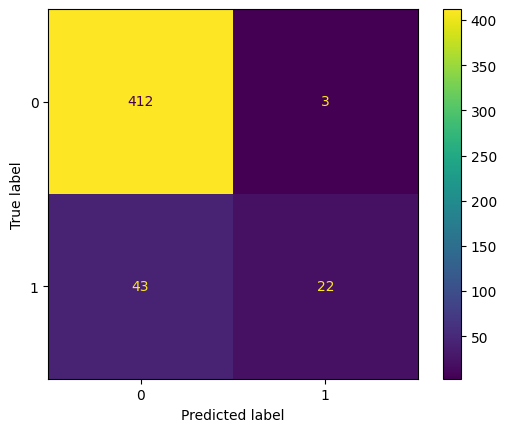

In [65]:
# Raw confusion matrix
raw_matrix = metrics.confusion_matrix(py_test, py_pred)
print(f"Confusion matrix:\n{raw_matrix}")

# nicely visualized
metrics.ConfusionMatrixDisplay.from_predictions(py_test, py_pred);

### <span style="color:teal"> Receiver Operating Characteristic (ROC) and Precision-Recall (PR) Curves

#### Understanding decision functions and classification thresholds

Classifiers usually work by computing some real value of an observation, and then thresholding, such that if that value is larger than the threshold, the observation is labeled as one class (say the positive class), while if it is smaller then it will be the other class.

These values are either computed as probabilities or through a decision function. For example, for a given observation $x$ and a given threshold $\tau$:
$$
C_1: f(x) \ge \tau \\
C_0: f(x) < \tau
$$

Choosing a good threshold is not always trivial. Our running example (the SVM), has a 'natural', geometrically motivaded threshold of $0$. However, other thresholds could be better depending on our case and our data. To study those, we use the ROC curve and the PR curve.

**(Note)** Some classifiers will use probabilities instead of the decision function. Furthermore, for some classifiers using decision functions, you can also convert decision function values to probabilities. In the case of SVC, you need to indicate `probability=True` when creating the `svm.SVC()` object.

The decision function values will be needed to compute the ROC curve:

In [66]:
# By default, SVC does not compute probabilities, but we can get the decision functions values:
py_dfunc_values = port_wine_pipeline.decision_function(pX_test)
py_dfunc_values[0:20]

array([-1.29790281, -1.09194051, -1.10176649, -1.12974832, -1.32714634,
       -1.20742612, -1.39115739, -1.24024576, -1.00004521, -1.23621845,
       -1.08953367, -0.96103076, -1.3276137 , -0.7777825 , -1.17444207,
       -1.19769345,  0.60136173, -1.3525244 , -0.95604438, -1.01988701])

By default, our classifier has a threshold of $\tau_{default}=0$. Hence, it should map the negative values to the $0^{th}$ class and the positive ones to the $1^{th}$ class.

In [67]:
py_pred = port_wine_pipeline.predict(pX_test)
dfunc_df = pd.DataFrame({"decision_function": py_dfunc_values, "predicted_class": py_pred})
dfunc_df.head(20)

,decision_function,predicted_class
0,-1.297903,0
1,-1.091941,0
2,-1.101766,0
3,-1.129748,0
4,-1.327146,0
5,-1.207426,0
6,-1.391157,0
7,-1.240246,0
8,-1.000045,0
9,-1.236218,0


Remember that now from all of these predicted values, which were obtained using the default threshold $\tau=0$, we obtain particular performance metrics, for example the true positive rate (recall):

In [68]:
print(f"TPR (tau=0): {pw_clf_recall:.2f}")

TPR (tau=0): 0.34


Hopefully this clarifies the relationship between the decision function, thresholds, predicted classes, and overall performance.

**Computing values for ROC curve**

We can compute the raw ROC values:

In [69]:
# Will return false postive rates, true positive rates, and the threshold those values belong to
fpr, tpr, thresholds = metrics.roc_curve(py_test, py_dfunc_values)

How are these related? Let's look at the threshold `sklearn` tried, and the resulting FPR values per threshold:

In [70]:
thresholds

array([        inf,  1.21717019,  0.39827136,  0.38841677,  0.35934486,
        0.33145083,  0.26774805,  0.23714662,  0.02044853, -0.07650539,
       -0.16260752, -0.39868845, -0.46309746, -0.47349215, -0.53123261,
       -0.55118628, -0.59521042, -0.5999714 , -0.61066896, -0.61693491,
       -0.65390574, -0.65713825, -0.68908904, -0.72395033, -0.73413125,
       -0.75477077, -0.75742969, -0.7756029 , -0.80726017, -0.81993187,
       -0.8596334 , -0.86040939, -0.93809038, -0.94444221, -0.96380949,
       -0.96524292, -1.00507709, -1.0059164 , -1.01857725, -1.01988701,
       -1.02559992, -1.02759428, -1.03367218, -1.03424199, -1.03704702,
       -1.04167869, -1.05424462, -1.05576446, -1.07016142, -1.07034823,
       -1.0728325 , -1.07521376, -1.08514911, -1.08667357, -1.09823758,
       -1.09861655, -1.10780639, -1.10840309, -1.11414445, -1.11545685,
       -1.1220132 , -1.12226082, -1.12256242, -1.12974832, -1.12992283,
       -1.182836  , -1.18312906, -1.18591113, -1.18667064, -1.18

In [71]:
fpr

array([0.        , 0.        , 0.        , 0.00240964, 0.00240964,
       0.00481928, 0.00481928, 0.00722892, 0.00722892, 0.01445783,
       0.01445783, 0.02891566, 0.02891566, 0.0313253 , 0.0313253 ,
       0.03373494, 0.03855422, 0.03855422, 0.04337349, 0.04337349,
       0.04578313, 0.04578313, 0.05060241, 0.05060241, 0.05542169,
       0.05542169, 0.05783133, 0.05783133, 0.06506024, 0.06506024,
       0.07228916, 0.07228916, 0.12048193, 0.12048193, 0.13253012,
       0.13253012, 0.21445783, 0.21927711, 0.25060241, 0.25060241,
       0.26506024, 0.26506024, 0.27710843, 0.28192771, 0.28915663,
       0.28915663, 0.32048193, 0.32048193, 0.33975904, 0.33975904,
       0.34457831, 0.34939759, 0.37349398, 0.37349398, 0.39277108,
       0.39277108, 0.41927711, 0.41927711, 0.44578313, 0.44578313,
       0.47228916, 0.47710843, 0.47710843, 0.48433735, 0.48915663,
       0.59759036, 0.60240964, 0.60963855, 0.61445783, 0.61686747,
       0.61686747, 0.6313253 , 0.6313253 , 0.64819277, 0.64819

Notice that when our decision threshold is very high, we don't have any False Positives. That makes sense because we are being overly strict on what we consider a positive, so almost no point will be missclassified as such.

The more we reduced our threshold, the more false positives we get, and hence a higher FPR. By the time we make our threshold super small, such that basically everything is considered class 1, we missclassify all the negatives a positive and hence get FPR of $1$.

Let's plot how TPR and FPR change individually as we change thresholds.

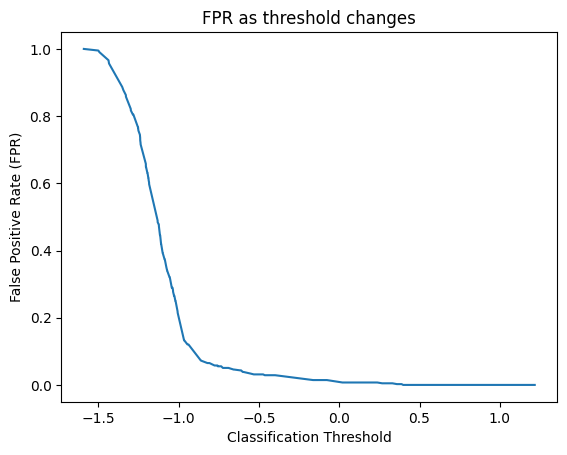

In [72]:
plt.plot(thresholds, fpr)
plt.xlabel("Classification Threshold")
plt.ylabel("False Positive Rate (FPR)")
plt.title("FPR as threshold changes")
plt.show()

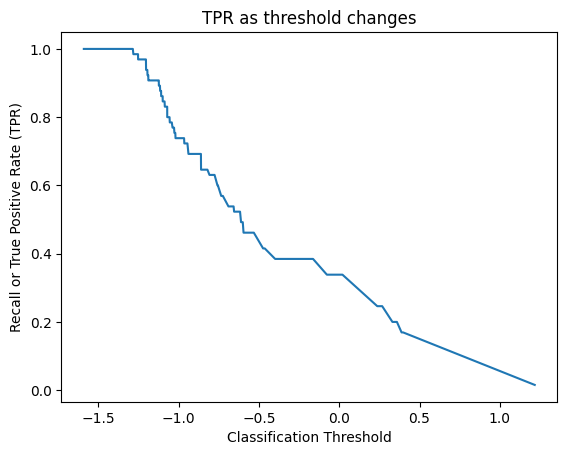

In [73]:
plt.plot(thresholds, tpr)
plt.xlabel("Classification Threshold")
plt.ylabel("Recall or True Positive Rate (TPR)")
plt.title("TPR as threshold changes")
plt.show()

#### The ROC Curve

We can now display FPR vs TPR. The ROC curve does NOT display the thresholds themselves.

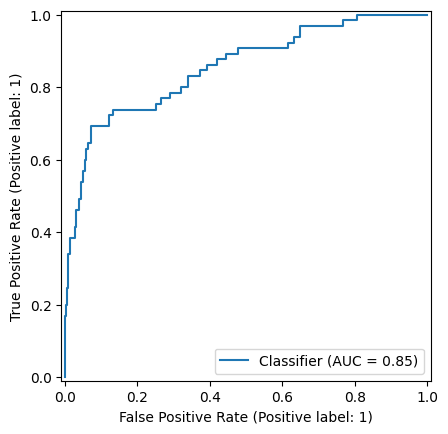

In [74]:
metrics.RocCurveDisplay.from_predictions(py_test, py_dfunc_values);
# The semi-colon suppresses unnescessary matplotlib output

**Interpretation**
- Ideally we want our classifier to have as high a TPR and as low an FPR as possible. Hence, we must choose the threshold achieving the point closest to the top left (thresholds are not shown in the figure above).
- The curve is a visual summary of how our classifier works for a variety of thresholds, the area under the curve (AUC in the plot) is an aggregate of how the classifier performs over all thresholds.

#### The PR Curve

The Precision-Recall curve works similar to the ROC but with Precision vs Recall.
- Ideally, we would have both high recall (TPR) and high precision (fraction of true positives to everything we classified as positive).
- So we would want a right-upward bulging arc.

Now let's compute the precision recall curve.

In [75]:
# Raw option, useful when thresholds are needed
pw_clf_precision, pw_clf_recall, pw_clf_pr_thresholds = metrics.precision_recall_curve(py_test, py_dfunc_values)

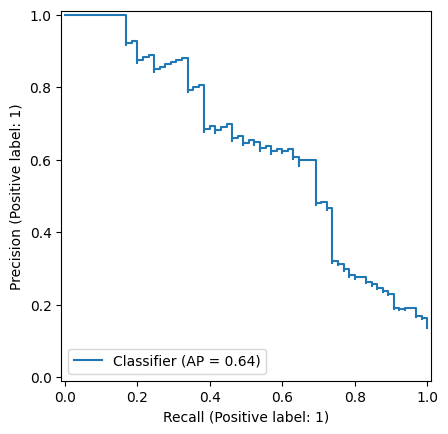

In [76]:
# Visual option, for quick overall reading of behavior
metrics.PrecisionRecallDisplay.from_predictions(py_test, py_dfunc_values);

**Interpretation**
- Aha! The PR curve, which ideally is as pushed to the top right as possible, is pretty bad. This was not clear with the ROC curve. The PR curve is better at diagnosing problems when data is imbalanced.
- A one-number metric summarizing the curve above is the average precision (AP), which weights precision based on recall increases. The exact formula is in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html)

#### <span style="color:red">EXERCISE</span>
<hr>

1. Discuss with your neighbors what the shapes of ROC and PR curves can tell us about a classifier.
3. Why, in the case of imbalanced data, would the PR be more informative than the ROC?

<hr>

#### When and how to use the ROC and PR curves

You can use the curves in two scenarios:

1. **Threshold Selection.** If you have a classifier or model you are sure to use, you can use the above curves to choose a specific threshold.
    - For example, you can find the point on the ROC curve with highest TPR given an FPR tolerance.
    - Or, using the PR curve, you can find the threshold that optimizes a trade-off between precision and recall, like maximizing the $F_1$ score.

2. **Model Selection.** If you want to compare performance among classifiers or models.
    - In this case, you can obtain an overall summary of performance with the ROC area under the curve (AUC) or the PR average precision (AP), and pick the model that maximizes these.

And remember that when your classes are imbalanced, PR is preferable to ROC.

In the next section we will talk about cross-validation, the ML go-to framework to compare among models!